In [175]:
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import string
import random

from nltk.corpus import stopwords
from pathlib import Path
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.stem.snowball import EnglishStemmer
from gensim.models import Word2Vec as w2v
# from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import defaultdict

# constants
ROOT = Path().absolute()
txt_mus = open(ROOT/"data/musicas_short.txt", "r", encoding='utf-8')
lyrics = txt_mus.read()
sw = stopwords.words('english')
plt.style.use('ggplot')
# nltk.download('punkt')
# nltk.download('stopwords')

In [2]:
songs_list = lyrics.split("\n\nXXXXXXXXXX\n\n")
songs_list.pop()

all_lyrics = []
for song in songs_list:
    lyrics1 = song.split("\n---\n")
    lyrics = lyrics1[0].split("\n>> ") + [lyrics1[1]]
    all_lyrics.append(lyrics)

In [3]:
all_lyrics[315:317]

[["I Can't Make You Love Me",
  'soul',
  "Turn down the lights\nTurn down the bed\nTurn down these voices\nInside my head\n\nLay down with me\nTell me no lies\nJust hold me closely\nDon't patronize\nDon't patronize me\n\n'Cause I can't make you love me if you don't\nAnd you can't make your heart feel something that it won't\nAnd here in the dark, in these final hours\nI will lay down my heart and I will feel the power\nBut you won't, no, you won't\n'Cause I can't make you love me\nWhen you don't, when you don't\n\nI close my eyes\n'Cause then I won't see\nThe love you don't feel\nWhen you're home with me\n\nMorning will come\nAnd I'll do what's right\nJust give me till then\nTo give up this fight\nAnd I will give up this fight\n\n'Cause I can't make you love me if you don't\nAnd you can't make your heart feel something that it won't\nAnd here in the dark, in these final hours\nI will lay down my heart and I will feel the power\nBut you won't, no, you won't\n'Cause I can't make you lov

In [4]:
# # Selecionando conjunto de treinamento
# size = int(len(all_lyrics)*0.7)  # training set size
# train_sample_ids = random.sample(range(0, len(all_lyrics)), size)
# train_sample_ids.sort()
# train_sample_ids

[0,
 1,
 2,
 4,
 5,
 6,
 9,
 10,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 31,
 32,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 48,
 50,
 52,
 53,
 54,
 56,
 57,
 58,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 79,
 80,
 81,
 83,
 86,
 87,
 88,
 89,
 90,
 93,
 94,
 95,
 96,
 97,
 100,
 101,
 102,
 103,
 105,
 106,
 108,
 109,
 111,
 112,
 114,
 115,
 116,
 117,
 120,
 121,
 123,
 124,
 125,
 126,
 128,
 130,
 131,
 135,
 136,
 137,
 139,
 142,
 143,
 145,
 146,
 147,
 148,
 150,
 151,
 152,
 153,
 154,
 156,
 157,
 159,
 161,
 162,
 163,
 165,
 166,
 168,
 169,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 189,
 190,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 200,
 201,
 202,
 203,
 206,
 208,
 209,
 210,
 211,
 213,
 214,
 217,
 218,
 219,
 220,
 221,
 224,
 225,
 226,
 227,
 229,
 230,
 231,
 232,
 233,
 234,
 236,
 238,
 239,
 240,
 242,
 244,
 245,
 

In [5]:
# # Selecionando o conjunto de teste
# test_sample_ids = []
# for i in range(0, len(all_lyrics)):
#     if (i not in train_sample_ids):
#         test_sample_ids.append(i)

# # Verificando se a quantidade está certa
# (len(test_sample_ids) + len(train_sample_ids)) == len(all_lyrics)

True

In [6]:
# train_set = []
# for idx in train_sample_ids:
#     train_set.append(all_lyrics[idx])

# test_set = []
# for idx in test_sample_ids:
#     test_set.append(all_lyrics[idx])

In [28]:
# train_set
# test_set

In [41]:
# # Limpando e tokenizando os textos para o conjunto de treinamento
# swu = stopwords.words('english') + list(string.punctuation)
# stemmer = EnglishStemmer()

# clean_lyrics = {'titulo': [], 'musica':[], 'genero':[]}
# tokenizador = WordPunctTokenizer()
# for song in train_set:
#     current_song = []
#     current_title = []
#     song_lower = song[2].lower()
#     title_lower = song[0].lower()
#     genre = song[1]
#     for token in tokenizador.tokenize(song_lower):
#         if (token not in swu):
#             current_song.append(stemmer.stem(token))
#     for token in tokenizador.tokenize(title_lower):
#         if (token not in list(string.punctuation)):  # como os título são mais curtos, tira apenas as pontuações
#             # Se tirar as stopwords, muitos título ficam sem palavra nenhuma
#             current_title.append(stemmer.stem(token))
#     clean_lyrics['titulo'].append(current_title)
#     clean_lyrics['musica'].append(current_song)
#     clean_lyrics['genero'].append(genre)

In [239]:
# lyrics_train = pd.DataFrame(data = clean_lyrics)
# lyrics_train.head()

In [240]:
# Limpando e tokenizando os textos para o conjunto de treinamento
swu = stopwords.words('english') + list(string.punctuation)
stemmer = EnglishStemmer()

clean_lyrics = {'titulo': [], 'titulo tokenizado':[], 'musica completa':[], 'musica':[], 'genero':[]}
tokenizador = WordPunctTokenizer()

for song in all_lyrics:
    current_song = []
    current_title = []
    song_lower = song[2].lower()
    title_lower = song[0].lower()
    genre = song[1]
    for token in tokenizador.tokenize(song_lower):
        if (token not in swu):
            current_song.append(stemmer.stem(token))
    for token in tokenizador.tokenize(title_lower):
        if (token not in list(string.punctuation)):
            # Inclui apenas pontuação porque, como os títulos tendem a ter
            # menos palavras (e, muitas delas, stopwords), perde-se muita
            # informação ao excluir as stopwords.
            current_title.append(stemmer.stem(token))
    clean_lyrics['titulo'].append(title_lower)
    clean_lyrics['titulo tokenizado'].append(current_title)
    clean_lyrics['musica completa'].append(song[2])
    clean_lyrics['musica'].append(current_song)
    clean_lyrics['genero'].append(genre)

lyrics_df = pd.DataFrame(data = clean_lyrics)
lyrics_df.head()

,titulo,titulo tokenizado,musica completa,musica,genero
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop


In [241]:
lyrics_df['genero'].unique()

array(['pop', 'soul', 'indie', 'eletronica', 'pop rock', 'rock and roll',
       'hard rock', 'reggae', 'heavy metal', 'gospel', 'hip hop/rap',
       'punk rock', 'alternativo', 'folk'], dtype=object)

### Tentativa de reorganizar as classificações e diminuir a quantidade de classes existentes
Primeiramente, excluir músicas de alguns gêneros com menos ocorrências e menos informção contida nas letras, para facilitar as análises. Foram, assim, excluídas as seguintes categorias:
* eletronica
* reggae
* heavy metal
* punk rock
* soul

Em seguida, optou-se por reunir alguns gêneros semelhantes sob uma mesma categoria, da seguinte forma:
* pop, pop rock -> pop (0)
* rock and roll, hard rock -> rock (1)
* indie, alternativo, folk -> indie/alternativo (2)
* hip hop/rap -> hip hop/rap (3)
* gospel -> gospel (4)
* eletronica, reggae, heavy metal, punk rock, soul -> excluídos do dataframe (5)

In [242]:
dicio_target = {'pop':0, 'soul':5, 'indie':2, 'eletronica':5, 'pop rock':0, 'rock and roll':1,\
                'hard rock':1, 'reggae':5, 'heavy metal':5, 'gospel':4, 'hip hop/rap':3,\
                'punk rock':5, 'alternativo':2, 'folk':2}

lyrics_df['Target'] = lyrics_df.apply(lambda x: dicio_target[x['genero']], axis=1)
lyrics_df

,titulo,titulo tokenizado,musica completa,musica,genero,Target
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop,0
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop,0
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop,0
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
...,...,...,...,...,...,...
9335,we all die trying to get it right,"[we, all, die, tri, to, get, it, right]",Think you're in control until you're not\nAnd ...,"[think, control, love, find, place, alon, find...",folk,2
9336,we're going home,"[we, re, go, home]",Under the surface you don't know what you'll f...,"[surfac, know, find, hmm, time, second, chanc,...",folk,2
9337,where we start,"[where, we, start]",Storm rolled in to our surprise\nIt doesn't ra...,"[storm, roll, surpris, rain, tall, tree, love,...",folk,2
9338,who am i,"[who, am, i]",Hold me up to the light\nTell me if the sun co...,"[hold, light, tell, sun, come, shine, got, hea...",folk,2


In [244]:
# Excluindo a categoria 5
lyrics_df = lyrics_df.loc[lyrics_df['Target'] != 5].reset_index().drop(columns='index')
lyrics_df

,titulo,titulo tokenizado,musica completa,musica,genero,Target
0,34+35,"[34, 35]",Hmm\n\nYou might think I'm crazy\nThe way I've...,"[hmm, might, think, crazi, way, cravin, put, q...",pop,0
1,34+35 (remix) (feat. megan thee stallion &amp;...,"[34, 35, remix, feat, megan, thee, stallion, a...",[Ariana Grande]\nHmm\n\nYou might think I'm cr...,"[ariana, grand, hmm, might, think, crazi, way,...",pop,0
2,7 rings,"[7, ring]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
3,7 rings (live),"[7, ring, live]",Thank you\nDo you mind if we change our costum...,"[thank, mind, chang, costum, real, fast, got, ...",pop,0
4,7 rings (remix) (feat. 2 chainz),"[7, ring, remix, feat, 2, chainz]","Yeah, breakfast at Tiffany's and bottles of bu...","[yeah, breakfast, tiffani, bottl, bubbl, girl,...",pop,0
...,...,...,...,...,...,...
7041,we all die trying to get it right,"[we, all, die, tri, to, get, it, right]",Think you're in control until you're not\nAnd ...,"[think, control, love, find, place, alon, find...",folk,2
7042,we're going home,"[we, re, go, home]",Under the surface you don't know what you'll f...,"[surfac, know, find, hmm, time, second, chanc,...",folk,2
7043,where we start,"[where, we, start]",Storm rolled in to our surprise\nIt doesn't ra...,"[storm, roll, surpris, rain, tall, tree, love,...",folk,2
7044,who am i,"[who, am, i]",Hold me up to the light\nTell me if the sun co...,"[hold, light, tell, sun, come, shine, got, hea...",folk,2


## Breve análise exploratória dos dados:

In [245]:
count_df = lyrics_df.groupby('Target').count()
count_df

,titulo,titulo tokenizado,musica completa,musica,genero
Target,,,,,
0,2604,2604,2604,2604,2604
1,1771,1771,1771,1771,1771
2,1008,1008,1008,1008,1008
3,698,698,698,698,698
4,965,965,965,965,965


[Text(0.5, 1.0, 'Quantida de músicas de cada categoria\n')]

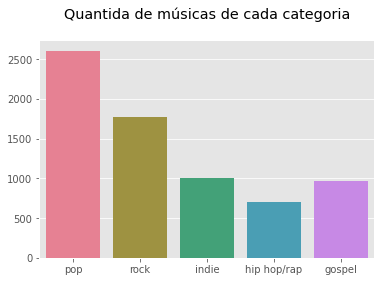

In [247]:
import seaborn as sns

target = ['pop','rock','indie','hip hop/rap','gospel']
count = count_df['musica'].tolist()

# sns.color_palette("hls", 8)
sns.barplot(x=target, y=count, palette='husl').set(title = 'Quantida de músicas de cada categoria\n')

In [248]:
titles_list =  lyrics_df['titulo'].tolist()
lyrics_list = lyrics_df['musica'].tolist()

In [75]:
# lyrics_list[2321]

In [70]:
# # Aqui é tudo pra treinamento
# list_titles = lyrics_train['titulo'].tolist()
# list_lyrics = lyrics_train['musica'].tolist()
# list_titles

### Brincando com os modelos do Word2Vec

In [249]:
titles_model = w2v(titles_list, min_count=5)
lyrics_model = w2v(lyrics_list, min_count=25)

def similar(word, where=1):
    if where == 0:
        similar = titles_model.wv.most_similar(stemmer.stem(word))
    elif where == 1:
        similar = lyrics_model.wv.most_similar(stemmer.stem(word))
    return similar

In [250]:
similar('lover')

[('kind', 0.5812344551086426),
 ('wolf', 0.4826037287712097),
 ('cruel', 0.48088425397872925),
 ('deepli', 0.46628934144973755),
 ('cover', 0.4564817547798157),
 ('woman', 0.45034271478652954),
 ('restless', 0.4410109519958496),
 ('victim', 0.4401082396507263),
 ('ev', 0.434292733669281),
 ('dizzi', 0.4331435561180115)]

In [251]:
similar('talk')

[('languag', 0.6282826066017151),
 ('tough', 0.5296577215194702),
 ('listen', 0.49727630615234375),
 ('talkin', 0.49069562554359436),
 ('walk', 0.47670814394950867),
 ('marri', 0.4667021334171295),
 ('hush', 0.45235827565193176),
 ('chat', 0.44479748606681824),
 ('curv', 0.44102340936660767),
 ('french', 0.42688843607902527)]

In [252]:
similar('money')

[('spend', 0.6351137161254883),
 ('earn', 0.6306842565536499),
 ('cash', 0.6181884407997131),
 ('bill', 0.6087808609008789),
 ('dolla', 0.600744366645813),
 ('rent', 0.5964794754981995),
 ('makin', 0.5769853591918945),
 ('pay', 0.5705312490463257),
 ('buy', 0.5588788390159607),
 ('dindu', 0.5533735156059265)]

In [253]:
similar('dead')

[('buri', 0.6667276620864868),
 ('woke', 0.539863109588623),
 ('death', 0.5102033615112305),
 ('led', 0.5038889646530151),
 ('headlin', 0.4966312050819397),
 ('awak', 0.4933241903781891),
 ('bed', 0.48592740297317505),
 ('live', 0.4820946156978607),
 ('soon', 0.4798181653022766),
 ('arriv', 0.47830361127853394)]

In [254]:
similar('god')

[('bless', 0.8585211038589478),
 ('almighti', 0.7728573083877563),
 ('reign', 0.6553285121917725),
 ('emmanuel', 0.6495912075042725),
 ('majesti', 0.6368724703788757),
 ('overcom', 0.6336689591407776),
 ('mighti', 0.6306023001670837),
 ('righteous', 0.6245895624160767),
 ('exalt', 0.617806077003479),
 ('glori', 0.6013029217720032)]

## Usando Word2Vec para fazer a classificação

In [226]:
# lyrics_df['musica'][20]

In [269]:
# Separando conjunto de treinamento e de teste:
X_train, X_test, y_train, y_test = train_test_split(lyrics_df['musica'], lyrics_df['Target'], test_size=0.3, shuffle=True)

In [270]:
X_train

2712    [belong, father, love, come, orphan, longer, b...
4725    [someth, kind, hit, today, look, wonder, saw, ...
832     [thinkin, bout, night, life, ladi, powder, roo...
6829    [one, two, three, four, woah, haha, oh, na, na...
3020    [oh, get, back, solid, ground, gonna, crawl, w...
                              ...                        
3126    [hey, havana, ooh, na, na, ay, half, heart, ha...
708     [chorus, gypsi, gypsi, danc, feet, gypsi, gyps...
1436    [stay, away, long, leav, mind, gone, thing, tr...
4144    [drake, yeah, yeah, drop, outta, school, dumb,...
1772    [good, day, sunshin, good, day, sunshin, good,...
Name: musica, Length: 4932, dtype: object

In [271]:
y_train

2712    4
4725    0
832     1
6829    2
3020    0
       ..
3126    0
708     1
1436    0
4144    3
1772    1
Name: Target, Length: 4932, dtype: int64

In [272]:
# Deixando os dados no formato necessário para a aplicação dos modelos do scikit learn
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def transform(self, X):
        return np.array([np.mean([self.word2vec[w] for w in words if w in self.word2vec] \
            or [np.zeros(self.dim)], axis=0) for words in X])

model = w2v(lyrics_df['musica'],min_count=1)
w2vec = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2vec)
X_train_ = modelw.transform(X_train)
X_test_ = modelw.transform(X_test)

In [273]:
X_train_

array([[-2.56591082e-01,  2.97797501e-01,  6.12838447e-01, ...,
        -5.66125333e-01, -4.98715162e-01,  2.41511777e-01],
       [ 2.00756956e-02,  6.71528652e-03,  1.61272645e-01, ...,
        -3.73398438e-02, -3.85234833e-01,  1.43105000e-01],
       [-1.98466005e-03,  7.72107393e-02,  2.43891418e-01, ...,
        -3.26550245e-01, -3.96453410e-01, -2.74656415e-01],
       ...,
       [ 2.69203812e-01,  1.20425585e-03,  3.40448409e-01, ...,
        -2.53203399e-02, -3.53810072e-01,  5.77624798e-01],
       [ 1.22850679e-01,  7.06648231e-02, -1.01176076e-01, ...,
        -1.73868820e-01, -2.34006763e-01,  7.73697793e-02],
       [ 3.86105739e-02,  1.75954588e-02,  4.00579691e-01, ...,
        -1.04304142e-02, -1.25826395e+00,  3.87265176e-01]])

In [260]:
# Definindo os modelos:
regressao_modelo1 = LogisticRegression(solver = 'newton-cg', class_weight='balanced')
# regressao_modelo2 = LogisticRegression(class_weight='balanced')
# Treinando os modelos:
regressao_modelo1.fit(X_train_, y_train)
# regressao_modelo2.fit(X_train_, y_train)

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [274]:
y_pred = regressao_modelo1.predict(X_test_)

In [275]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.67      0.32      0.44       820
           1       0.62      0.37      0.46       487
           2       0.27      0.61      0.38       299
           3       0.43      0.81      0.56       208
           4       0.77      0.94      0.85       300

    accuracy                           0.51      2114
   macro avg       0.55      0.61      0.54      2114
weighted avg       0.59      0.51      0.50      2114



In [277]:
print(X_test)
print('\n')
print(y_test)

6967    [come, chanc, come, chanc, hous, shoe, foot, r...
1665    [read, news, today, oh, boy, lucki, man, made,...
1414    [say, wrong, say, good, leav, alon, cuz, gonna...
4535    [come, johnni, yen, liquor, drug, flesh, machi...
3948    [option, hey, hey, hey, refus, forgotten, hey,...
                              ...                        
2939    [anybodi, fli, thing, head, explod, head, star...
2924    [lost, feel, alon, circumnavig, globe, ever, h...
5878    [one, generat, live, salvat, go, see, reviv, d...
970     [never, told, came, never, told, name, know, l...
5556    [upon, time, foot, great, mountain, town, peop...
Name: musica, Length: 2114, dtype: object


6967    2
1665    1
1414    0
4535    0
3948    3
       ..
2939    0
2924    0
5878    4
970     1
5556    2
Name: Target, Length: 2114, dtype: int64


In [278]:
print(lyrics_df.iloc[6967]) # primeira música do conjunto de teste
print('\n')
print(y_pred[0])

titulo                                                      no chances
titulo tokenizado                                          [no, chanc]
musica completa      We come for you, no chances\nWe come for you, ...
musica               [come, chanc, come, chanc, hous, shoe, foot, r...
genero                                                     alternativo
Target                                                               2
Name: 6967, dtype: object


2


In [303]:
boss_final = lyrics_df.loc[lyrics_df['titulo'] == 'take me to church']
boss_final = boss_final['musica'] #= boss_final

In [314]:
boss_final1 = lyrics_df.loc[lyrics_df['titulo'] == 'take me to church']
boss_final = boss_final1['musica']
# regressao_modelo1.predict(boos_final)
modelo_teste = w2v(boss_final,min_count=1)
w2vec_teste = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw_teste = MeanEmbeddingVectorizer(w2vec_teste)
boss_final_ = modelw_teste.transform(boss_final)
boss_final_

array([[ 6.65266663e-02, -4.00831029e-02, -1.96451899e-02,
        -1.53075621e-01,  2.38613114e-02, -5.18966794e-01,
         9.97628644e-03,  3.98087859e-01, -1.69528320e-01,
        -4.88653123e-01, -1.35041103e-01, -2.78832138e-01,
         1.97974280e-01,  4.43177640e-01, -3.47526044e-01,
         8.68985951e-02,  1.94903359e-01, -3.87222171e-01,
        -6.32465541e-01, -4.44918096e-01,  2.70472556e-01,
        -6.27089322e-01,  1.28732800e-01, -1.61043465e-01,
        -4.22083348e-01,  1.02925509e-01, -7.31309175e-01,
        -2.75535613e-01, -6.53707325e-01, -1.22721657e-01,
         1.81984559e-01,  1.75826028e-01,  3.97036135e-01,
        -3.85543108e-01,  6.07118383e-02,  4.04341936e-01,
         3.31723452e-01, -2.27090314e-01, -3.76382977e-01,
        -2.17996299e-01, -3.45011711e-01, -1.21165350e-01,
        -5.93442798e-01,  3.06293160e-01,  3.44647050e-01,
         2.87098974e-01, -5.54313600e-01,  3.76131944e-02,
         3.42763156e-01,  3.12030733e-01,  1.23480819e-0

In [317]:
regressao_modelo1.predict(boss_final_)
# boss_final

array([4, 0, 4], dtype=int64)

In [319]:
boss_final1

,titulo,titulo tokenizado,musica completa,musica,genero,Target
3645,take me to church,"[take, me, to, church]",My lover's got humour\nShe's the giggle at a f...,"[lover, got, humour, giggl, funer, know, every...",pop rock,0
4946,take me to church,"[take, me, to, church]","Yeah, yeah, yeah, yeah, yeah\nMy lover's got h...","[yeah, yeah, yeah, yeah, yeah, lover, got, hum...",pop,0
6476,take me to church,"[take, me, to, church]",My lover's got humour\nShe's the giggle at a f...,"[lover, got, humour, giggl, funer, know, every...",alternativo,2


No caso acima, uma mesma música (regravada por artistas que tocam gêneros diferentes) resultou em classificações distintas pelo modelo treinado. 